In [109]:
from functions import *

In [110]:
n = 5
T = 0.1

In [111]:
# Take a random spin glass model
m = RandomIsingModel(n=n, seed=0)
H_ising = np.diag(m.E_rescaled)
H_mixer = H_mixer_list[m.n-1]
d = int(2**m.n)

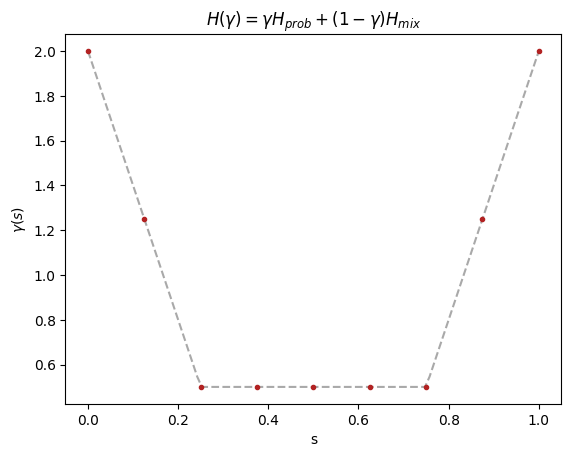

In [155]:
f_max = 0.5
t_max = 1

ramp_up_schedule = np.concatenate([np.linspace(2, 0.5, 3), np.ones(2)*0.5])
# ramp_up_schedule = np.concatenate([np.linspace(0, f_max, 3), np.ones(2)*f_max])
# ramp_up_schedule = np.ones(5)*f_max

schedule = get_symmetric_schedule(ramp_up_schedule)
schedule_interpolator = get_schedule_interpolator(schedule, kind='linear')

plot_schedule(schedule, schedule_interpolator)

In [156]:
# data = load_from_json('n5_cubic_cobyla_lbfgsb.json')

# n = data['n']
# t_max = data['t_max']
# interpolator_kind = data['interpolator_kind']

# schedule = data['schedule_finetuned']
# schedule_interpolator = get_schedule_interpolator(schedule, kind=interpolator_kind) # get an interpolating function for the continuos schedule

# plot_schedule(schedule, schedule_interpolator)

In [157]:
def s(t): return t/t_max # annealing fraction
def hamiltonian(t): return (1-schedule_interpolator(s(t)))*H_ising + schedule_interpolator(s(t))*H_mixer

In [158]:
def get_i_th_eigenstate(H, i):
    vals, vecs = np.linalg.eigh(H)
    return vecs[:, i].astype(complex)

In [209]:
psi_0 = get_i_th_eigenstate(H_ising, 0)

t_eval = np.linspace(0, t_max, 50)
psi_t = solve_state_tdse(hamiltonian, t_max, psi_0, return_intermediate=True, t_eval=t_eval)

In [210]:
def get_instanteneous_eigendecomposition(hamiltonian, t_eval):
    eigenstates = np.zeros((len(t_eval), len(hamiltonian(0)), len(hamiltonian(0))))
    eigenenergies = np.zeros((len(t_eval), len(hamiltonian(0))))
    for i, t in enumerate(t_eval):
        vals, vecs = np.linalg.eigh(hamiltonian(t))
        eigenstates[i, :] = vecs
        eigenenergies[i, :] = vals
    return eigenenergies, eigenstates

In [211]:
instanteneous_eigenenergies, instanteneous_eigenstates = get_instanteneous_eigendecomposition(hamiltonian, t_eval)

In [212]:
eigenstate_population_t = np.zeros((len(t_eval), d))
for i in range(len(t_eval)):
    eigenstate_population_t[i, :] = np.abs(instanteneous_eigenstates[i].T.conj() @ psi_t[i])**2

In [213]:
z_basis_population_t = np.zeros((len(t_eval), d))
for i in range(len(t_eval)):
    z_basis_population_t[i, :] = np.abs(psi_t[i])**2

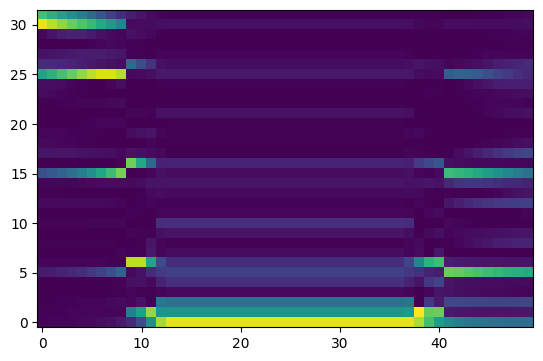

In [214]:
plt.imshow(eigenstate_population_t.T, origin='lower')
plt.show()

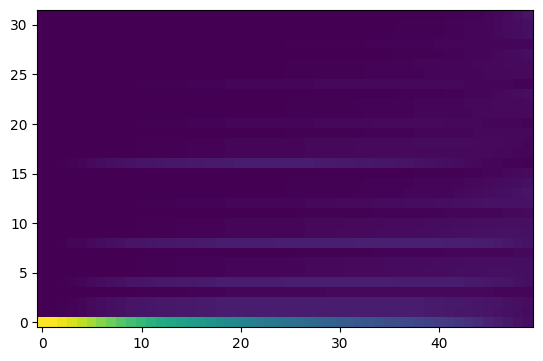

In [215]:
plt.imshow(z_basis_population_t.T, origin='lower')
plt.show()